In [1]:
# Import components
import datetime as dt
import math
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns
from matplotlib import pyplot as pltw
from pmdarima import arima, datasets, model_selection, utils
from scipy.spatial import distance
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import LocalOutlierFactor
from statsmodels.tsa.seasonal import STL

warnings.simplefilter("ignore")

plt.rcParams["font.family"] = "Hiragino Maru Gothic Pro"
plt.style.use("ggplot")  # グラフのスタイル
plt.rcParams["figure.figsize"] = [12, 9]  # グラフサイズ設定

In [2]:
df = pd.read_csv("../datasets/fixed_battery_log_2.csv")
df["date"] = pd.to_datetime(df["date"])
users = df["User"].unique()

In [3]:
df.head()

,User,date,battery,state,weekday,time_to_num
0,Narita,2021-12-04 01:52:00,60,ON,5,6773
1,Narita,2021-12-04 02:22:00,73,OFF,5,8566
2,Narita,2021-12-04 07:06:00,71,ON,5,25564
3,Narita,2021-12-04 07:15:00,73,OFF,5,26105
4,Narita,2021-12-04 07:15:00,73,ON,5,26113


In [20]:
bins = np.linspace(0, 100, 11)

In [10]:
hoge = pd.DataFrame(
    df.loc[(df["User"] == "Narita") & (df["state"] == "ON") & (df["weekday"] == 5)][
        "battery"
    ].copy()
)

In [11]:
foo = pd.DataFrame(
    df.loc[(df["User"] == "Narita") & (df["state"] == "ON") & (df["weekday"] == 1)][
        "battery"
    ].copy()
)

In [21]:
freq_1 = hoge["battery"].value_counts(bins=bins, sort=False)
rel_freq_1 = freq_1 / hoge["battery"].count()
class_value = (bins[:-1] + bins[1:]) / 2

In [22]:
freq_2 = foo["battery"].value_counts(bins=bins, sort=False)
rel_freq_2 = freq_2 / foo["battery"].count()

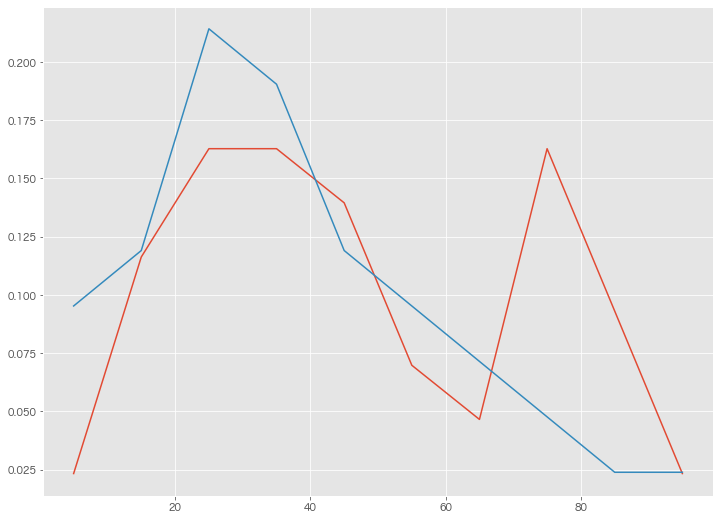

In [23]:
plt.plot(class_value, rel_freq_1)
plt.plot(class_value, rel_freq_2)

In [31]:
first_date_cand = pd.date_range("2022-01-01", "2022-02-01")
score_G = []
score_I = []

days = [7, 14, 21, 30]
weekdays = df["weekday"].unique()
data = df
clf = LocalOutlierFactor(n_neighbors=2)
bins = np.linspace(0, 100, 11)

for a in range(len(days)):
    diff_day_1 = days[a]
    for b in range(len(days)):
        diff_day_2 = days[b]
        for h in range(len(users)):
            user = users[h]
            for i in range(0, 101):
                first_date = first_date_cand[
                    np.random.randint(0, len(first_date_cand), 1)
                ]
                last_date = first_date + dt.timedelta(days=diff_day_1)
                weekday = np.random.choice(weekdays)
                imposters = users.copy()
                imposters = imposters[~(imposters == user)]
                imposter = np.random.choice(imposters)

                t_Q = pd.DataFrame(
                    data.loc[
                        (data["User"] == user)
                        & (data["state"] == "ON")
                        & (data["date"] > first_date[0] + dt.timedelta(seconds=1))
                        & (data["date"] < last_date[0])
                        & (data["weekday"] == weekday)
                    ]["battery"].copy()
                )
                t_Q = np.array(t_Q)
                t_Q = t_Q.reshape(len(t_Q), 1)
                try:
                    pred = clf.fit_predict(t_Q)
                except:
                    continue
                t_Q = t_Q[np.where(pred > 0)]
                t_Q = pd.DataFrame(t_Q, columns=["battery"])

                freq_1 = t_Q["battery"].value_counts(bins=bins, sort=False)
                t_Q = freq_1 / t_Q["battery"].count()

                t_T = pd.DataFrame(
                    data.loc[
                        (data["User"] == user)
                        & (data["state"] == "ON")
                        & (
                            data["date"]
                            > (first_date[0] - dt.timedelta(days=diff_day_2))
                        )
                        & (data["date"] < (first_date[0]))
                        & (data["weekday"] == weekday)
                    ]["battery"].copy()
                )
                t_T = np.array(t_T)
                t_T = t_T.reshape(len(t_T), 1)
                try:
                    pred = clf.fit_predict(t_T)
                except:
                    continue
                t_T = t_T[np.where(pred > 0)]
                t_T = pd.DataFrame(t_T, columns=["battery"])

                freq_2 = t_T["battery"].value_counts(bins=bins, sort=False)
                t_T = freq_2 / t_T["battery"].count()

                i_Q = pd.DataFrame(
                    data.loc[
                        (data["User"] == imposter)
                        & (data["state"] == "ON")
                        & (data["date"] > first_date[0] + dt.timedelta(seconds=1))
                        & (data["date"] < last_date[0])
                        & (data["weekday"] == weekday)
                    ]["battery"].copy()
                )
                i_Q = np.array(i_Q)
                i_Q = i_Q.reshape(len(i_Q), 1)
                try:
                    pred = clf.fit_predict(i_Q)
                except:
                    continue
                i_Q = i_Q[np.where(pred > 0)]
                i_Q = pd.DataFrame(i_Q, columns=["battery"])

                freq_3 = i_Q["battery"].value_counts(bins=bins, sort=False)
                i_Q = freq_3 / i_Q["battery"].count()
                try:
                    score_G.append(distance.euclidean(t_T.values, t_Q.values))
                    score_I.append(distance.euclidean(t_T.values, i_Q.values))
                except:
                    pass

        grand_truth = np.concatenate((np.ones(len(score_G)), np.zeros(len(score_I))))
        score = np.concatenate((score_G, score_I))
        far, tpr, threshold = metrics.roc_curve(grand_truth, score)
        auc = metrics.auc(far, tpr)
        frr = 1.0 - tpr
        eer = far[np.where((far - frr) < 0)[0][-1]]
        print(eer)

0.6392857142857142
0.6389776357827476
0.594704684317719
0.6420029895366218
0.643671917436176
0.6514423076923077
0.6450899905273129
0.65134994807892
0.6525832376578645
0.6506740681998414
0.6492201039861352
0.6456984273820536
0.6457264957264958
0.6473323859966412
0.6431603773584905
0.6438014737754659


In [32]:
first_date_cand = pd.date_range("2022-01-01", "2022-02-01")
score_G = []
score_I = []

days = [7, 14, 21, 30]
# weekdays = df["weekday"].unique()
data = df
clf = LocalOutlierFactor(n_neighbors=2)
bins = np.linspace(0, 100, 11)

for a in range(len(days)):
    diff_day_1 = days[a]
    for b in range(len(days)):
        diff_day_2 = days[b]
        for h in range(len(users)):
            user = users[h]
            for i in range(0, 101):
                first_date = first_date_cand[
                    np.random.randint(0, len(first_date_cand), 1)
                ]
                last_date = first_date + dt.timedelta(days=diff_day_1)
                weekday = np.random.choice(weekdays)
                imposters = users.copy()
                imposters = imposters[~(imposters == user)]
                imposter = np.random.choice(imposters)

                t_Q = pd.DataFrame(
                    data.loc[
                        (data["User"] == user)
                        & (data["state"] == "ON")
                        & (data["date"] > first_date[0] + dt.timedelta(seconds=1))
                        & (data["date"] < last_date[0])
                        # & (data["weekday"] == weekday)
                    ]["battery"].copy()
                )
                t_Q = np.array(t_Q)
                t_Q = t_Q.reshape(len(t_Q), 1)
                try:
                    pred = clf.fit_predict(t_Q)
                except:
                    continue
                t_Q = t_Q[np.where(pred > 0)]
                t_Q = pd.DataFrame(t_Q, columns=["battery"])

                freq_1 = t_Q["battery"].value_counts(bins=bins, sort=False)
                t_Q = freq_1 / t_Q["battery"].count()

                t_T = pd.DataFrame(
                    data.loc[
                        (data["User"] == user)
                        & (data["state"] == "ON")
                        & (
                            data["date"]
                            > (first_date[0] - dt.timedelta(days=diff_day_2))
                        )
                        & (data["date"] < (first_date[0]))
                        # & (data["weekday"] == weekday)
                    ]["battery"].copy()
                )
                t_T = np.array(t_T)
                t_T = t_T.reshape(len(t_T), 1)
                try:
                    pred = clf.fit_predict(t_T)
                except:
                    continue
                t_T = t_T[np.where(pred > 0)]
                t_T = pd.DataFrame(t_T, columns=["battery"])

                freq_2 = t_T["battery"].value_counts(bins=bins, sort=False)
                t_T = freq_2 / t_T["battery"].count()

                i_Q = pd.DataFrame(
                    data.loc[
                        (data["User"] == imposter)
                        & (data["state"] == "ON")
                        & (data["date"] > first_date[0] + dt.timedelta(seconds=1))
                        & (data["date"] < last_date[0])
                        # & (data["weekday"] == weekday)
                    ]["battery"].copy()
                )
                i_Q = np.array(i_Q)
                i_Q = i_Q.reshape(len(i_Q), 1)
                try:
                    pred = clf.fit_predict(i_Q)
                except:
                    continue
                i_Q = i_Q[np.where(pred > 0)]
                i_Q = pd.DataFrame(i_Q, columns=["battery"])

                freq_3 = i_Q["battery"].value_counts(bins=bins, sort=False)
                i_Q = freq_3 / i_Q["battery"].count()
                try:
                    score_G.append(distance.euclidean(t_T.values, t_Q.values))
                    score_I.append(distance.euclidean(t_T.values, i_Q.values))
                except:
                    pass

        grand_truth = np.concatenate((np.ones(len(score_G)), np.zeros(len(score_I))))
        score = np.concatenate((score_G, score_I))
        far, tpr, threshold = metrics.roc_curve(grand_truth, score)
        auc = metrics.auc(far, tpr)
        frr = 1.0 - tpr
        eer = far[np.where((far - frr) < 0)[0][-1]]
        print(eer)

0.7066831683168316
0.7271039603960396
0.7405115511551155
0.7484529702970297
0.7455445544554455
0.7526815181518152
0.7554809052333805
0.7597462871287128
0.7608635863586358
0.7636138613861386
0.766989198919892
0.7706270627062707
0.7668507235338918
0.7698019801980198
0.7721122112211221
0.7743657178217822
